In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import rasterio
import pyvista as pv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Cropping2D
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import vtk
from vtk.util import numpy_support as VN
from skimage.metrics import structural_similarity
import random
from time import time
import random

# Helper Functions

In [2]:
sample_factor = 4
size = 128

In [5]:
# ----- this function gives the difference between the mass and momentum solver ----- #
def get_mass_momentum_diff(file_number, wind_direction_folder, wind_direction_file, vegetation_type, plot=True):
    mass_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/{vegetation_type}/{wind_direction_folder}/{wind_direction_file}ang.asc"
    mass_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/{vegetation_type}/{wind_direction_folder}/{wind_direction_file}vel.asc"

    momentum_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/{vegetation_type}/{wind_direction_folder}/{wind_direction_file}ang.asc"
    momentum_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/{vegetation_type}/{wind_direction_folder}/{wind_direction_file}vel.asc"

    with rasterio.open(mass_angle_file) as ang_src_mass, rasterio.open(mass_vel_file) as vel_src_mass:
        angle_mass = ang_src_mass.read(1)  # Wind direction in degrees
        velocity_mass = vel_src_mass.read(1)  # Wind speed in m/s
        transform_mass = ang_src_mass.transform  # Georeferencing
        width_mass, height_mass = ang_src_mass.width, ang_src_mass.height  # Raster dimensions

    # Convert wind direction to U, V components for quiver plot
    angle_rad_mass = np.radians(angle_mass)  # Convert degrees to radians
    U_mass = velocity_mass * np.cos(angle_rad_mass)  # X component
    V_mass = velocity_mass * np.sin(angle_rad_mass)  # Y component
    N_orig = U_mass.shape[0]
    # Downsample for visualization (adjust factor for performance)
    X_mass, Y_mass = np.meshgrid(np.arange(0, width_mass, sample_factor), np.arange(0, height_mass, sample_factor))
    U_sampled_mass = U_mass[::sample_factor, ::sample_factor]
    V_sampled_mass = V_mass[::sample_factor, ::sample_factor]

    with rasterio.open(momentum_angle_file) as ang_src_momentum, rasterio.open(momentum_vel_file) as vel_src_momentum:
        angle_momentum = ang_src_momentum.read(1)  # Wind direction in degrees
        velocity_momentum = vel_src_momentum.read(1)  # Wind speed in m/s
        transform_momentum = ang_src_momentum.transform  # Georeferencing
        width_momentum, height_momentum = ang_src_momentum.width, ang_src_momentum.height  # Raster dimensions

    # Convert wind direction to U, V components for quiver plot
    angle_rad_momentum = np.radians(angle_momentum)  # Convert degrees to radians
    U_momentum = velocity_momentum * np.cos(angle_rad_momentum)  # X component
    V_momentum = velocity_momentum * np.sin(angle_rad_momentum)  # Y component

    # Downsample for visualization (adjust factor for performance)
    X_momentum, Y_momentum = np.meshgrid(np.arange(0, width_momentum, sample_factor), np.arange(0, height_momentum, sample_factor))
    U_sampled_momentum = U_momentum[::sample_factor, ::sample_factor]
    V_sampled_momentum = V_momentum[::sample_factor, ::sample_factor]

    # print(mean_squared_error(U_sampled_mass, U_sampled_momentum))
    # calculate the difference
    U_diff = U_sampled_momentum - U_sampled_mass
    V_diff = V_sampled_momentum - V_sampled_mass

    min_dimension = np.min([U_diff.shape[0], U_diff.shape[1]])
    U_diff = U_diff[:size, :size]
    V_diff = V_diff[:size, :size]

    X_diff = X_mass[:size, :size]
    Y_diff = Y_mass[:size, :size]

    U_ssim = structural_similarity(U_sampled_momentum, U_sampled_mass, data_range=np.max(U_sampled_momentum) - np.min(U_sampled_momentum))
    V_ssim = structural_similarity(V_sampled_momentum, V_sampled_mass, data_range=np.max(V_sampled_momentum) - np.min(V_sampled_momentum))
    ssim = np.mean([U_ssim, V_ssim])

    elevation = get_elevation_file(file_number)
    # plot

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        im1 = ax1.imshow(velocity_mass, cmap="coolwarm", origin="upper")  # Wind speed heatmap
        ax1.quiver(X_mass, Y_mass, U_sampled_mass, -V_sampled_mass, scale=300, color="black")  # Wind direction arrows

        ax1.set_title("Mass Solver")
        ax1.set_xlabel("X")
        ax1.set_ylabel("Y")

        ax2.quiver(X_momentum, Y_momentum, U_sampled_momentum, -V_sampled_momentum, scale=300, color="black")  # Wind direction arrows

        ax2.set_title("Momentum Solver")
        ax2.set_xlabel("X")
        ax2.set_ylabel("Y")

        fig.tight_layout()
        plt.show()

        # plot the difference...
        fig = plt.figure(figsize=(10,8))
        
        plt.imshow(elevation, extent=[0, N_orig, N_orig, 0], cmap="coolwarm", origin="upper")
        plt.quiver(X_diff, Y_diff, U_diff, -V_diff, scale=300, color="black")
        plt.title("Difference")
        plt.xlabel('X')
        plt.ylabel("Y")
        plt.show()

    return U_diff, V_diff, ssim
    


In [6]:
# ----- this function takes in an elevation grid and reduces it to a grid of size N x X ----- 
def split_elevation(elevation, N, plot=True):
    rows, cols = elevation.shape

    if N >= rows or N >= cols:
        N = min(rows, cols) - 1

    block_size_x = rows // N
    block_size_y = cols // N
    new_elevation = np.zeros((N,N))

    for i in range(N):
        for j in range(N):
            block = elevation[i * block_size_x:(i + 1) * block_size_x, j * block_size_y:(j + 1) * block_size_y]
            
            new_elevation[i, j] = np.mean(block)
    
    if plot:
        figure = plt.figure(figsize=(10,12))
        
        ax1 = figure.add_subplot(121)
        ax1.imshow(elevation)
        ax1.set_title("Original Elevation")

        
        ax2 = figure.add_subplot(122)
        ax2.imshow(new_elevation)
        ax2.set_title(f"Approximated Elevation, N = {N}")
        plt.show()

    return new_elevation




In [7]:
# ----- gets the elevation grid for a file number ------
def get_elevation_file(file_number):
    elevation_tif = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/dem0.tif"
    with rasterio.open(elevation_tif) as src:
        elevation = src.read(1)  # Reads all bands into a NumPy array
        elevation_npy = np.array(elevation)


    elevation_approx = split_elevation(elevation_npy, size, plot=False)
    return elevation_approx


In [8]:
# ----- gets the output of the mass-conserving solver for file file_number -----
def get_mass_grid(file_number, wind_direction_file, wind_direction_folder, vegetation_type):
    mass_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/{vegetation_type}/{wind_direction_folder}/{wind_direction_file}ang.asc"
    mass_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/{vegetation_type}/{wind_direction_folder}/{wind_direction_file}vel.asc"
    
    with rasterio.open(mass_angle_file) as ang_src_mass, rasterio.open(mass_vel_file) as vel_src_mass:
        angle_mass = ang_src_mass.read(1)  # Wind direction in degrees
        velocity_mass = vel_src_mass.read(1)  # Wind speed in m/s
        transform_mass = ang_src_mass.transform  # Georeferencing
        width_mass, height_mass = ang_src_mass.width, ang_src_mass.height  # Raster dimensions

    # Convert wind direction to U, V components for quiver plot
    angle_rad_mass = np.radians(angle_mass)  # Convert degrees to radians
    U_mass = velocity_mass * np.cos(angle_rad_mass)  # X component
    V_mass = velocity_mass * np.sin(angle_rad_mass)  # Y component

    # Downsample for visualization (adjust factor for performance)
    sample_factor = 4  # Change this to control arrow density
    X_mass, Y_mass = np.meshgrid(np.arange(0, width_mass, sample_factor), np.arange(0, height_mass, sample_factor))
    U_sampled_mass = U_mass[::sample_factor, ::sample_factor]
    V_sampled_mass = V_mass[::sample_factor, ::sample_factor]

    U_sampled_mass = U_sampled_mass[:size, :size]
    V_sampled_mass = V_sampled_mass[:size, :size]

    return U_sampled_mass, V_sampled_mass

In [9]:
# ----- gets the output of the mass- and momentum-conserving solver for file file_number -----
def get_momentum_grid(file_number, wind_direction_file, wind_direction_folder):
    momentum_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/grass/{wind_direction_folder}/{wind_direction_file}ang.asc"
    momentum_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/grass/{wind_direction_folder}/{wind_direction_file}vel.asc"
    
    with rasterio.open(momentum_angle_file) as ang_src_momentum, rasterio.open(momentum_vel_file) as vel_src_momentum:
        angle_momentum = ang_src_momentum.read(1)  # Wind direction in degrees
        velocity_momentum = vel_src_momentum.read(1)  # Wind speed in m/s
        transform_momentum = ang_src_momentum.transform  # Georeferencing
        width_momentum, height_momentum = ang_src_momentum.width, ang_src_momentum.height  # Raster dimensions

    # Convert wind direction to U, V components for quiver plot
    angle_rad_momentum = np.radians(angle_momentum)  # Convert degrees to radians
    U_momentum = velocity_momentum * np.cos(angle_rad_momentum)  # X component
    V_momentum = velocity_momentum * np.sin(angle_rad_momentum)  # Y component

    # Downsample for visualization (adjust factor for performance)
    sample_factor = 4  # Change this to control arrow density
    X_momentum, Y_momentum = np.meshgrid(np.arange(0, width_momentum, sample_factor), np.arange(0, height_momentum, sample_factor))
    U_sampled_momentum = U_momentum[::sample_factor, ::sample_factor]
    V_sampled_momentum = V_momentum[::sample_factor, ::sample_factor]

    U_sampled_momentum = U_sampled_momentum[:size, :size]
    V_sampled_momentum = V_sampled_momentum[:size, :size]

    return U_sampled_momentum, V_sampled_momentum

In [10]:
# ----- checks whether we should use the file at file_number (checks for null values, empty files, etc) ------
def should_use_num(file_number, wind_direction_file, wind_direction_folder, vegetation_type):

    mass_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/{vegetation_type}/{wind_direction_folder}/{wind_direction_file}ang.asc"
    mass_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/{vegetation_type}/{wind_direction_folder}/{wind_direction_file}vel.asc"
    momentum_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/{vegetation_type}/{wind_direction_folder}/{wind_direction_file}ang.asc"
    momentum_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/{vegetation_type}/{wind_direction_folder}/{wind_direction_file}vel.asc"
    elevation_tif = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/dem0.tif"

    if not os.path.exists(mass_angle_file):
        return False
    
    if not os.path.exists(mass_vel_file):
        return False
    
    if not os.path.exists(momentum_angle_file):
        return False
    
    if not os.path.exists(momentum_vel_file):
        return False
    
    if not os.path.exists(elevation_tif):
        return False
    
    return True

# Data Loading

In [13]:
# ------ Generate random sets of training and testing indices ----- #
test_idx = list(set([random.randint(0, 160) for i in range(30)]))
train_idx = list(range(0, 200))
for k in test_idx:
    try:
        train_idx.remove(k)
    except:
        continue
print(len(test_idx))
print(len(train_idx))

28
172


In [14]:
print(test_idx)
print(train_idx)

[131, 132, 6, 7, 135, 9, 10, 141, 15, 148, 150, 157, 34, 38, 49, 52, 63, 68, 82, 83, 85, 92, 97, 99, 108, 117, 121, 126]
[0, 1, 2, 3, 4, 5, 8, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 84, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 127, 128, 129, 130, 133, 134, 136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 147, 149, 151, 152, 153, 154, 155, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]


In [15]:
# Lists to store data
X_train_list, y_train_list = [], []

train_ssims = []
wind_direction_folder_names = ['0o0deg', '22o5deg', '45o0deg', '67o5deg', '90o0deg', '112o5deg', '135o0deg', '157o5deg', '180o0deg', '202o5deg', '225o0deg', '247o5deg', '270o0deg', '292o5deg', '315o0deg', '337o5deg']
wind_direction_file_names = ['dem0_0_5_100m_', 'dem0_23_5_100m_', 'dem0_45_5_100m_', 'dem0_68_5_100m_', 'dem0_90_5_100m_', 'dem0_113_5_100m_', 'dem0_135_5_100m_', 'dem0_158_5_100m_', 'dem0_180_5_100m_', 'dem0_203_5_100m_', 'dem0_225_5_100m_', 'dem0_248_5_100m_', 'dem0_270_5_100m_', 'dem0_293_5_100m_', 'dem0_315_5_100m_', 'dem0_338_5_100m_']
wind_directions = np.linspace(0,337.5, 16)

for file_num in train_idx:  
    print("File Number: ", file_num)
    for vegetation_type in ['brush', 'grass', 'trees']:
        for i in range(16):

            wind_direction_folder = wind_direction_folder_names[i]
            wind_direction_file = wind_direction_file_names[i]
            # Load data for this file
            if not should_use_num(file_num, wind_direction_file, wind_direction_folder, vegetation_type):
                continue

            try: 
                U_diff, V_diff, ssim = get_mass_momentum_diff(file_num, wind_direction_folder, wind_direction_file, vegetation_type, plot=False)
                train_ssims.append(ssim)
                elevation = get_elevation_file(file_num)
                U_mass, V_mass = get_mass_grid(file_num, wind_direction_file, wind_direction_folder, vegetation_type)

                # Convert to NumPy arrays (if they aren't already)
                U_diff, V_diff = np.array(U_diff), np.array(V_diff)
                elevation = np.array(elevation)
                U_mass, V_mass = np.array(U_mass), np.array(V_mass)

                # Ensure correct shape (size, size)
                assert U_diff.shape == (size, size) and V_diff.shape == (size, size)
                assert elevation.shape == (size, size)
                assert U_mass.shape == (size, size) and V_mass.shape == (size, size)

                # Stack inputs into a (size, size, 3) tensor
                X_sample = np.stack([elevation, U_mass, V_mass], axis=-1)  # Shape: (size, size, 3)

                # Stack targets into a (size, size, 2) tensor
                y_sample = np.stack([U_diff, V_diff], axis=-1)  # Shape: (size, size, 2)
                # Append to lists
                X_train_list.append(X_sample)
                y_train_list.append(y_sample)
            except:
                continue

# Convert lists to NumPy arrays
X_train = np.array(X_train_list)  # Shape: (10, size, size, 3)
y_train = np.array(y_train_list)  # Shape: (10, size, size, 2)


# Convert to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

print(X_train.shape)


File Number:  0
File Number:  1
File Number:  2
File Number:  3
File Number:  4
File Number:  5
File Number:  8
File Number:  11
File Number:  12
File Number:  13
File Number:  14
File Number:  16
File Number:  17
File Number:  18
File Number:  19
File Number:  20
File Number:  21
File Number:  22
File Number:  23
File Number:  24
File Number:  25
File Number:  26
File Number:  27
File Number:  28
File Number:  29
File Number:  30
File Number:  31
File Number:  32
File Number:  33
File Number:  35
File Number:  36
File Number:  37
File Number:  39
File Number:  40
File Number:  41
File Number:  42
File Number:  43
File Number:  44
File Number:  45
File Number:  46
File Number:  47
File Number:  48
File Number:  50
File Number:  51
File Number:  53
File Number:  54
File Number:  55
File Number:  56
File Number:  57
File Number:  58
File Number:  59
File Number:  60
File Number:  61
File Number:  62
File Number:  64
File Number:  65
File Number:  66
File Number:  67
File Number:  69
File

In [16]:
print("MSE of mass and CFD solver: ")
original_mse = np.mean(np.square(y_train))
print(original_mse)

print("MAE of mass and CFD solver: ")
original_mae = np.mean(np.abs(y_train))
print(original_mae)

print("SSIM of mass and CFD solver: ")
original_ssim = np.mean(train_ssims)
print(original_ssim)



MSE of mass and CFD solver: 
5.6712956
MAE of mass and CFD solver: 
1.5264684
SSIM of mass and CFD solver: 
0.6078790807768389


In [25]:
X_test_list, y_test_list = [], []
test_ssims = []
for file_num in test_idx:  
    print(file_num)
    for vegetation_type in ['brush', 'grass', 'trees']:
        for i in range(16):
            wind_direction_file = wind_direction_file_names[i]
            wind_direction_folder = wind_direction_folder_names[i]

            if not should_use_num(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder, vegetation_type=vegetation_type):
                continue

            try:
                # Load data for this file
                U_diff, V_diff, ssim = get_mass_momentum_diff(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder, vegetation_type = vegetation_type, plot=False)
                test_ssims.append(ssim)
                elevation = get_elevation_file(file_num)
                U_mass, V_mass = get_mass_grid(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder, vegetation_type=vegetation_type)

                # Convert to NumPy arrays (if they aren't already)
                U_diff, V_diff = np.array(U_diff), np.array(V_diff)
                elevation = np.array(elevation)
                U_mass, V_mass = np.array(U_mass), np.array(V_mass)

                # Ensure correct shape (size, size)
                assert U_diff.shape == (size, size) and V_diff.shape == (size, size)
                assert elevation.shape == (size, size)
                assert U_mass.shape == (size, size) and V_mass.shape == (size, size)

                # Stack inputs into a (size, size, 3) tensor
                X_sample = np.stack([elevation, U_mass, V_mass], axis=-1)  # Shape: (size, size, 3)

                # Stack targets into a (size, size, 2) tensor
                y_sample = np.stack([U_diff, V_diff], axis=-1)  # Shape: (size, size, 2)

                # Append to lists
                X_test_list.append(X_sample)
                y_test_list.append(y_sample)
            except:
                continue

# Convert lists to NumPy arrays
X_test = np.array(X_test_list)  # Shape: (10, size, size, 3)
y_test = np.array(y_test_list)  # Shape: (10, size, size, 2)


# Convert to TensorFlow tensors
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

131
132
6
7
135
9
10
141
15
148
150
157
34
38
49
52
63
68
82
83
85
92
97
99
108
117
121
126


In [48]:
# Lists to store data
X_train_annotated_list, y_train_annotated_list = [], []

annotated_train_ssims = []
wind_direction_folder_names = ['0o0deg', '22o5deg', '45o0deg', '67o5deg', '90o0deg', '112o5deg', '135o0deg', '157o5deg', '180o0deg', '202o5deg', '225o0deg', '247o5deg', '270o0deg', '292o5deg', '315o0deg', '337o5deg']
wind_direction_file_names = ['dem0_0_5_100m_', 'dem0_23_5_100m_', 'dem0_45_5_100m_', 'dem0_68_5_100m_', 'dem0_90_5_100m_', 'dem0_113_5_100m_', 'dem0_135_5_100m_', 'dem0_158_5_100m_', 'dem0_180_5_100m_', 'dem0_203_5_100m_', 'dem0_225_5_100m_', 'dem0_248_5_100m_', 'dem0_270_5_100m_', 'dem0_293_5_100m_', 'dem0_315_5_100m_', 'dem0_338_5_100m_']
wind_directions = np.linspace(0,337.5, 16)

for file_num in train_idx:  
    print("File Number: ", file_num)
    for vegetation_type in ['brush', 'grass', 'trees']:
        for i in range(16):

            wind_direction_folder = wind_direction_folder_names[i]
            wind_direction_file = wind_direction_file_names[i]
            # Load data for this file
            if not should_use_num(file_num, wind_direction_file, wind_direction_folder, vegetation_type):
                continue


            U_diff, V_diff, ssim = get_mass_momentum_diff(file_num, wind_direction_folder, wind_direction_file, vegetation_type, plot=False)
            annotated_train_ssims.append(ssim)
            elevation = get_elevation_file(file_num)
            U_mass, V_mass = get_mass_grid(file_num, wind_direction_file, wind_direction_folder, vegetation_type)

            # Convert to NumPy arrays (if they aren't already)
            U_diff, V_diff = np.array(U_diff), np.array(V_diff)
            elevation = np.array(elevation)
            U_mass, V_mass = np.array(U_mass), np.array(V_mass)

            # Ensure correct shape (size, size)
            assert U_diff.shape == (size, size) and V_diff.shape == (size, size)
            assert elevation.shape == (size, size)
            assert U_mass.shape == (size, size) and V_mass.shape == (size, size)

            vegetation_grid = np.ones_like(U_mass)

            if vegetation_type == 'brush':
                vegetation_grid *= 1
            elif vegetation_type == 'grass':
                vegetation_grid *= 2
            elif vegetation_type == 'trees':
                vegetation_grid *= 3

            wind_angle_grid = np.ones_like(U_mass) * wind_directions[i]
            

            # Stack inputs into a (size, size, 3) tensor
            X_sample = np.stack([elevation, vegetation_grid, wind_angle_grid, U_mass, V_mass], axis=-1)  # Shape: (size, size, 5)

            # Stack targets into a (size, size, 2) tensor
            y_sample = np.stack([U_diff, V_diff], axis=-1)  # Shape: (size, size, 2)
            # Append to lists
            X_train_annotated_list.append(X_sample)
            y_train_annotated_list.append(y_sample)

# Convert lists to NumPy arrays
X_train_annotated = np.array(X_train_annotated_list)  # Shape: (10, size, size, 5)
y_train_annotated = np.array(y_train_annotated_list)  # Shape: (10, size, size, 2)


# Convert to TensorFlow tensors
X_train_annotated = tf.convert_to_tensor(X_train_annotated, dtype=tf.float32)
y_train_annotated = tf.convert_to_tensor(y_train_annotated, dtype=tf.float32)

print(X_train_annotated.shape)


File Number:  30
File Number:  31
File Number:  32
File Number:  33
File Number:  34
File Number:  35
File Number:  36
File Number:  37
File Number:  38
File Number:  39
File Number:  40
File Number:  41
File Number:  42
File Number:  43
File Number:  44
File Number:  45
File Number:  46
File Number:  47
File Number:  48
File Number:  49
File Number:  50
File Number:  51
File Number:  52
File Number:  53
File Number:  54
File Number:  55
File Number:  56
File Number:  57
File Number:  58
File Number:  59
File Number:  60
File Number:  61
File Number:  62
File Number:  63
File Number:  64
File Number:  65
File Number:  66
File Number:  67
File Number:  68
File Number:  69
File Number:  70
File Number:  71
File Number:  72
File Number:  73
File Number:  74
File Number:  75
File Number:  76
File Number:  77
File Number:  78
File Number:  79
File Number:  80
File Number:  81
File Number:  82
File Number:  83
File Number:  84
File Number:  85
File Number:  86
File Number:  87
File Number:  

In [50]:
X_test_annotated_list, y_test_annotated_list = [], []
annotated_test_ssims = []
for file_num in test_idx:  
    print(file_num)
    for vegetation_type in ['brush', 'grass', 'trees']:
        for i in range(16):
            wind_direction_file = wind_direction_file_names[i]
            wind_direction_folder = wind_direction_folder_names[i]

            if not should_use_num(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder, vegetation_type=vegetation_type):
                continue
            # Load data for this file
            U_diff, V_diff, ssim = get_mass_momentum_diff(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder, vegetation_type = vegetation_type, plot=False)
            annotated_test_ssims.append(ssim)
            elevation = get_elevation_file(file_num)
            U_mass, V_mass = get_mass_grid(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder, vegetation_type=vegetation_type)

            # Convert to NumPy arrays (if they aren't already)
            U_diff, V_diff = np.array(U_diff), np.array(V_diff)
            elevation = np.array(elevation)
            U_mass, V_mass = np.array(U_mass), np.array(V_mass)

            # Ensure correct shape (size, size)
            assert U_diff.shape == (size, size) and V_diff.shape == (size, size)
            assert elevation.shape == (size, size)
            assert U_mass.shape == (size, size) and V_mass.shape == (size, size)

            vegetation_grid = np.ones_like(U_mass)

            if vegetation_type == 'brush':
                vegetation_grid *= 1
            elif vegetation_type == 'grass':
                vegetation_grid *= 2
            elif vegetation_type == 'trees':
                vegetation_grid *= 3

            wind_angle_grid = np.ones_like(U_mass) * wind_directions[i]

            # Stack inputs into a (size, size, 3) tensor
            X_sample = np.stack([elevation, vegetation_grid, wind_angle_grid, U_mass, V_mass], axis=-1)  # Shape: (size, size, 5)

            # Stack targets into a (size, size, 2) tensor
            y_sample = np.stack([U_diff, V_diff], axis=-1)  # Shape: (size, size, 2)

            # Append to lists
            X_test_annotated_list.append(X_sample)
            y_test_annotated_list.append(y_sample)

# Convert lists to NumPy arrays
X_test_annotated = np.array(X_test_annotated_list)  # Shape: (10, size, size, 3)
y_test_annotated = np.array(y_test_annotated_list)  # Shape: (10, size, size, 2)


# Convert to TensorFlow tensors
X_test_annotated = tf.convert_to_tensor(X_test_annotated, dtype=tf.float32)
y_test_annotated = tf.convert_to_tensor(y_test_annotated, dtype=tf.float32)

4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


# Models

In [17]:
# this is defined for all of our models
input_shape = (size, size, 3)  # Elevation (1 channel) + Mass solver (2 channels)
# input_shape = (size, size, 5) # for annotated data
output_shape = (size, size, 2)  # Target difference (2 channels)

## Small Model

In [205]:
# Define small model
def build_small_model():
    inputs = keras.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Bottleneck
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)

    # Decoder
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)

    # Output layer
    outputs = layers.Conv2D(2, (1,1), activation="linear", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

# Create model
small_model = build_small_model()
small_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
small_model.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_140 (Conv2D)             │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_141 (Conv2D)             │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_142 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_143 (Conv2D)             │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_144 (Conv2D)             │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_145 (Conv2D)             │ (None, 128, 128, 2)    │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,570 (724.88 KB)

 Trainable params: 185,570 (724.88 KB)

 Non-trainable params: 0 (0.00 B)

In [206]:
# Example training
small_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 95s 375ms/step - loss: 2028.4541 - mae: 9.5410 - val_loss: 7.3127 - val_mae: 1.8388
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 105s 420ms/step - loss: 5.8729 - mae: 1.6524 - val_loss: 5.7410 - val_mae: 1.6543
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 103s 410ms/step - loss: 4.4101 - mae: 1.4203 - val_loss: 4.8580 - val_mae: 1.4616
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 99s 395ms/step - loss: 3.8656 - mae: 1.3145 - val_loss: 5.1281 - val_mae: 1.4826
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 105s 418ms/step - loss: 3.7369 - mae: 1.2857 - val_loss: 4.7319 - val_mae: 1.4933
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 99s 395ms/step - loss: 3.7350 - mae: 1.2927 - val_loss: 4.6877 - val_mae: 1.4190
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 99s 397ms/step - loss: 3.5048 - mae: 1.2394 - val_loss: 4.8170 - val_mae: 1.4614
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 87s 346ms/step - loss: 3.3956 - mae: 1.2130 - val_loss: 4.4889 - val_mae: 1.4304
Epoch 9/50
250/250 ━━━━━━━

In [207]:
# compute scores for the small model
small_model_predictions = small_model.predict(X_test) 

small_mse = mean_squared_error(y_test.numpy().flatten(), small_model_predictions.flatten())
small_mae = mean_absolute_error(y_test.numpy().flatten(), small_model_predictions.flatten())
small_ssim = structural_similarity(y_test.numpy().flatten(), small_model_predictions.flatten(), data_range = np.max(y_test.numpy().flatten()) - np.min(y_test.numpy().flatten()))
print("Small Model Errors")
print("MSE: ", small_mse)
print("MAE: ", small_mae)
print("SSIM: ", small_ssim)

38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step
Small Model Errors
MSE:  2.3147764
MAE:  1.0181639
SSIM:  0.7041633998550233


In [38]:
small_model.fit(X_train_annotated, y_train_annotated, epochs=50, batch_size=16, validation_split=0.2)

Epoch 1/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 109s 366ms/step - loss: 1099.8289 - mae: 10.0921 - val_loss: 6.4018 - val_mae: 1.7238
Epoch 2/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 104s 353ms/step - loss: 4.6228 - mae: 1.4283 - val_loss: 4.7778 - val_mae: 1.4637
Epoch 3/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 104s 352ms/step - loss: 3.7817 - mae: 1.2928 - val_loss: 4.7366 - val_mae: 1.4338
Epoch 4/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 107s 362ms/step - loss: 3.6606 - mae: 1.2649 - val_loss: 4.5472 - val_mae: 1.4251
Epoch 5/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 108s 364ms/step - loss: 3.5300 - mae: 1.2433 - val_loss: 4.6736 - val_mae: 1.4270
Epoch 6/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 105s 354ms/step - loss: 3.5085 - mae: 1.2416 - val_loss: 4.5638 - val_mae: 1.4461
Epoch 7/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 103s 350ms/step - loss: 3.2483 - mae: 1.1851 - val_loss: 4.1091 - val_mae: 1.3480
Epoch 8/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 106s 360ms/step - loss: 3.2175 - mae: 1.1700 - val_loss: 4.0556 - val_mae: 1.3286
Epoch 9/50
295/295 ━

In [39]:
small_model_prediction = small_model.predict(X_test_annotated) 

small_mse = mean_squared_error(y_test_annotated.numpy().flatten(), small_model_predictions.flatten())
small_mae = mean_absolute_error(y_test_annotated.numpy().flatten(), small_model_predictions.flatten())
small_ssim = structural_similarity(y_test_annotated.numpy().flatten(), small_model_predictions.flatten(), data_range = np.max(y_test_annotated.numpy().flatten()) - np.min(y_test_annotated.numpy().flatten()))
print("Small Model Errors")
print("MSE: ", small_mse)
print("MAE: ", small_mae)
print("SSIM: ", small_ssim)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step
Small Model Errors
MSE:  2.85431
MAE:  1.030957
SSIM:  0.7413663966790321


## Large Model

In [18]:
def build_large_model():
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation="relu", padding="same")(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation="relu", padding="same")(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = layers.Concatenate()([u6, c4]) 
    c6 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = layers.Concatenate()([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c7)
    u8 = layers.Concatenate()([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(u8)
    c8 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c8)
    u9 = layers.Concatenate()([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u9)
    c9 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c9)

    # Output layer
    outputs = layers.Conv2D(2, (1, 1), activation="linear")(c9)  

    model = Model(inputs, outputs)
    return model

# Example usage:
large_model = build_large_model()
large_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
large_model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,031,810 (118.38 MB)

 Trainable params: 31,031,810 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
large_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)

Epoch 1/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 1733s 7s/step - loss: 538651.5625 - mae: 78.3759 - val_loss: 5.5067 - val_mae: 1.4997
Epoch 2/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 1488s 6s/step - loss: 4.9343 - mae: 1.4629 - val_loss: 4.3918 - val_mae: 1.3612
Epoch 3/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 1038s 4s/step - loss: 4.0999 - mae: 1.3554 - val_loss: 4.5106 - val_mae: 1.4605
Epoch 4/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 1806s 7s/step - loss: 4.0000 - mae: 1.3483 - val_loss: 4.4989 - val_mae: 1.4475
Epoch 5/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 1856s 7s/step - loss: 4.0732 - mae: 1.3594 - val_loss: 4.4253 - val_mae: 1.4191
Epoch 6/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 1887s 7s/step - loss: 3.9900 - mae: 1.3399 - val_loss: 4.1661 - val_mae: 1.3461
Epoch 7/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 1037s 4s/step - loss: 3.9474 - mae: 1.3286 - val_loss: 4.1155 - val_mae: 1.3383
Epoch 8/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 1970s 8s/step - loss: 3.9357 - mae: 1.3324 - val_loss: 4.4013 - val_mae: 1.4055
Epoch 9/50
258/258 ━━━━━━━━━━━━━━━

In [26]:
# get the large model error scores
large_model_predictions = large_model.predict(X_test) 

large_mse = mean_squared_error(y_test.numpy().flatten(), large_model_predictions.flatten())
large_mae = mean_absolute_error(y_test.numpy().flatten(), large_model_predictions.flatten())
large_ssim = structural_similarity(y_test.numpy().flatten(), large_model_predictions.flatten(), data_range = np.max(y_test.numpy().flatten()) - np.min(y_test.numpy().flatten()))
print("Large Model Errors")
print("MSE: ", large_mse)
print("MAE: ", large_mae)
print("SSIM: ", large_ssim)

36/36 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step
Large Model Errors
MSE:  2.380684
MAE:  1.0604193
SSIM:  0.7110465747802188


In [52]:
large_model_annotated = build_large_model()
large_model_annotated.compile(optimizer="adam", loss="mse", metrics=["mae"])
large_model_annotated.fit(X_train_annotated, y_train_annotated, epochs=50, batch_size=16, validation_split=0.2)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2265s 9s/step - loss: 5056.6865 - mae: 14.6823 - val_loss: 6.6630 - val_mae: 1.8047
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1445s 6s/step - loss: 4.7163 - mae: 1.4410 - val_loss: 4.9126 - val_mae: 1.5039
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1938s 8s/step - loss: 4.0499 - mae: 1.3515 - val_loss: 5.2924 - val_mae: 1.6073
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2243s 9s/step - loss: 4.0331 - mae: 1.3512 - val_loss: 4.8912 - val_mae: 1.5147
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2874s 12s/step - loss: 3.9240 - mae: 1.3288 - val_loss: 4.8163 - val_mae: 1.4644
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1394s 6s/step - loss: 3.7956 - mae: 1.3021 - val_loss: 5.0786 - val_mae: 1.5197
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1447s 6s/step - loss: 3.7240 - mae: 1.2830 - val_loss: 4.4707 - val_mae: 1.3913
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1461s 6s/step - loss: 3.6140 - mae: 1.2535 - val_loss: 4.1670 - val_mae: 1.3409
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━

In [53]:
large_model_predictions_annotated = large_model_annotated.predict(X_test_annotated) 

large_mse_annotated = mean_squared_error(y_test_annotated.numpy().flatten(), large_model_predictions_annotated.flatten())
large_mae_annotated = mean_absolute_error(y_test_annotated.numpy().flatten(), large_model_predictions_annotated.flatten())
large_ssim_annotated = structural_similarity(y_test_annotated.numpy().flatten(), large_model_predictions_annotated.flatten(), data_range = np.max(y_test_annotated.numpy().flatten()) - np.min(y_test_annotated.numpy().flatten()))
print("Large Model Errors")
print("MSE: ", large_mse_annotated)
print("MAE: ", large_mae_annotated)
print("SSIM: ", large_ssim_annotated)

38/38 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step
Large Model Errors
MSE:  1.7508818
MAE:  0.8555406
SSIM:  0.767496823400003


## Medium Model

In [76]:
def build_medium_model():
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)


    # Bottleneck
    c5 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c5 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = layers.Concatenate()([u6, c2]) 
    c6 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c7)

    # Output layer
    outputs = layers.Conv2D(2, (1, 1), activation="linear")(c7)  

    model = Model(inputs, outputs)
    return model

# Example usage:
medium_model = build_medium_model()
medium_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
medium_model.summary()



Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_123 (Conv2D) │ (None, 128, 128,  │      1,792 │ input_layer_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_124 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_123[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 64, 64,    │          0 │ conv2d_124[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_125 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_26… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_126 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_125[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 32, 32,    │          0 │ conv2d_126[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_127 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_27… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_128 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_127[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_24 │ (None, 64, 64,    │    131,200 │ conv2d_128[0][0]  │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_24      │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_126[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_129 (Conv2D) │ (None, 64, 64,    │    295,040 │ concatenate_24[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_130 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_129[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_25 │ (None, 128, 128,  │     32,832 │ conv2d_130[0][0]  │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_25      │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_124[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_131 (Conv2D) │ (None, 128, 128,  │     73,792 │ concatenate_25[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_132 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_131[0][0]

 Total params: 1,862,914 (7.11 MB)

 Trainable params: 1,862,914 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
medium_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2538s 10s/step - loss: 765.3489 - mae: 7.2243 - val_loss: 6.6753 - val_mae: 1.6969
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 710s 3s/step - loss: 5.4085 - mae: 1.5441 - val_loss: 6.8571 - val_mae: 1.7983
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 737s 3s/step - loss: 5.2278 - mae: 1.5317 - val_loss: 4.9578 - val_mae: 1.4957
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 754s 3s/step - loss: 4.0897 - mae: 1.3569 - val_loss: 5.3248 - val_mae: 1.5834
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 751s 3s/step - loss: 3.9906 - mae: 1.3350 - val_loss: 5.4554 - val_mae: 1.6391
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 771s 3s/step - loss: 3.8804 - mae: 1.3183 - val_loss: 4.8370 - val_mae: 1.4879
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 778s 3s/step - loss: 3.8476 - mae: 1.3081 - val_loss: 4.8404 - val_mae: 1.4745
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 796s 3s/step - loss: 3.8338 - mae: 1.3014 - val_loss: 4.8953 - val_mae: 1.4913
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 804s

In [78]:
# get the error metrics for the medium model
medium_model_predictions = medium_model.predict(X_test) 

medium_mse = mean_squared_error(y_test.numpy().flatten(), medium_model_predictions.flatten())
medium_mae = mean_absolute_error(y_test.numpy().flatten(), medium_model_predictions.flatten())
medium_ssim = structural_similarity(y_test.numpy().flatten(), medium_model_predictions.flatten(), data_range = np.max(y_test.numpy().flatten()) - np.min(y_test.numpy().flatten()))
print("Medium Model Errors")
print("MSE: ", medium_mse)
print("MAE: ", medium_mae)
print("SSIM: ", medium_ssim)

38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step
Medium Model Errors
MSE:  1.5000076
MAE:  0.8069352
SSIM:  0.7770453602986227


In [ ]:
medium_model_annotated = build_medium_model()
medium_model_annotated.compile(optimizer="adam", loss="mse", metrics=["mae"])


In [ ]:
medium_model_annotated.fit(X_train_annotated, y_train_annotated, epochs=50, batch_size=16, validation_split=0.2)

## Image Generation

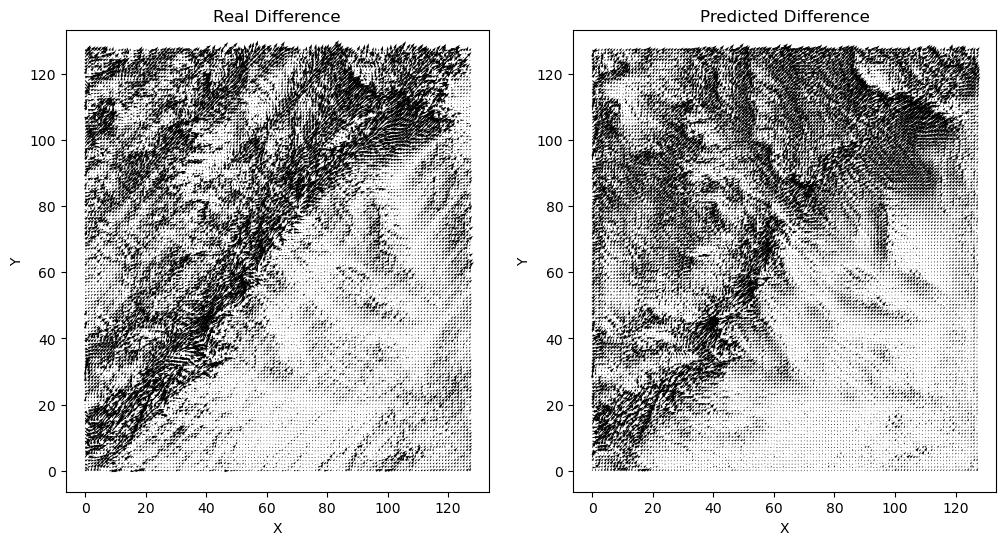

In [156]:
# ----- this plots the output of the neural network next to the true output of the CFD solver for qualitative analysis -----
def generate_difference_image(i=0):

    if i >= y_test.shape[0]:
        print("i is too large")
        return

    U_diff_test = y_test[i, :, :, 0]
    V_diff_test = y_test[i, :, :, 1]

    U_diff_pred = large_model_predictions[i, :, :, 0]
    V_diff_pred = large_model_predictions[i, :, :, 1]


    fig = plt.figure(figsize=(12,6))

    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.quiver(U_diff_test, -V_diff_test, scale=300, color="black")
    ax1.set_title("Real Difference")
    ax1.set_xlabel('X')
    ax1.set_ylabel("Y")

    ax2.quiver(U_diff_pred, -V_diff_pred, scale=300, color="black")
    ax2.set_title("Predicted Difference")
    ax2.set_xlabel('X')
    ax2.set_ylabel("Y")

    plt.show()



generate_difference_image(629)


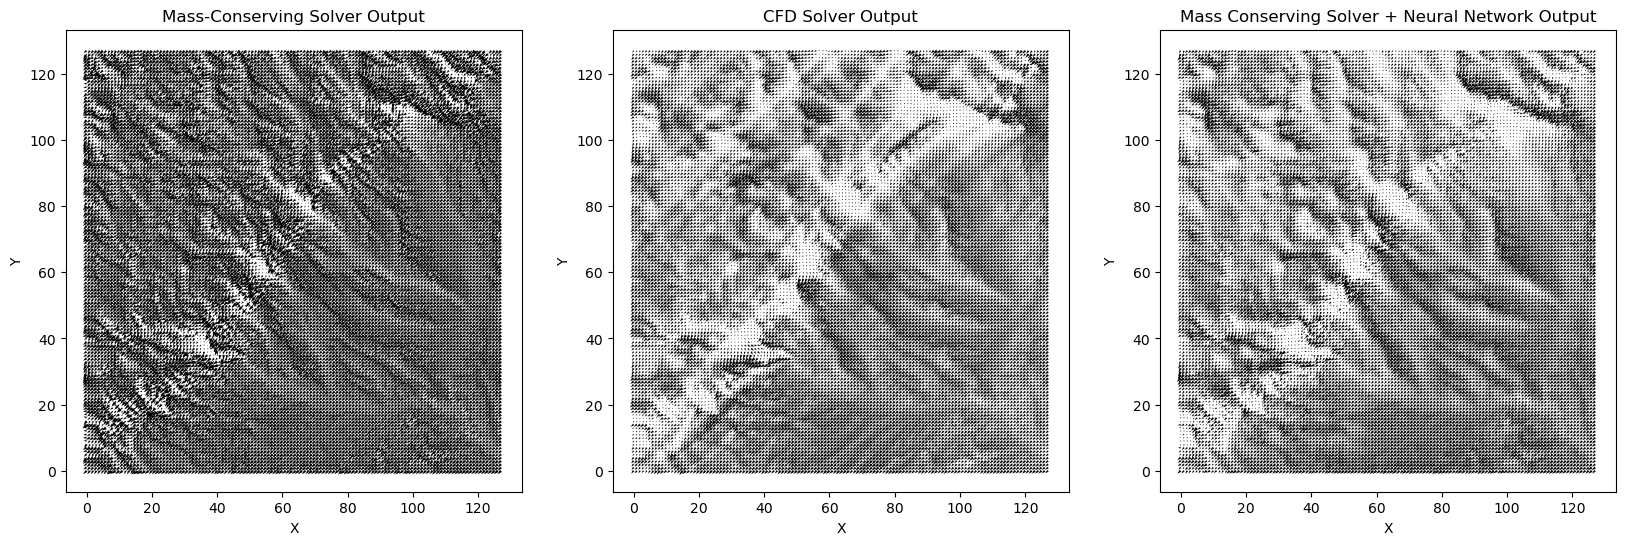

In [157]:
def generate_image(i=0):
    # file_num = test_idx[round(i/48)]
    # elevation_grid = get_elevation_file(file_num)

    mass_grid_U = X_test[i, :, :, 1]
    mass_grid_V = X_test[i, :, :, 2]
    
    difference_U = y_test[i, :, :, 0]
    difference_V = y_test[i, :, :, 1]
    
    
    predicted_difference_U = large_model_predictions[i, :, :, 0]
    predicted_difference_V = large_model_predictions[i, :, :, 1]

    momentum_grid_U = mass_grid_U + difference_U
    momentum_grid_V = mass_grid_V + difference_V

    predicted_grid_U = mass_grid_U + predicted_difference_U
    predicted_grid_V = mass_grid_V + predicted_difference_V

    fig = plt.figure(figsize=(20,6))

    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    scale = 1000

    ax1.quiver(mass_grid_U, -mass_grid_V, scale=scale, color="black")
    ax1.set_title("Mass-Conserving Solver Output")
    ax1.set_xlabel('X')
    ax1.set_ylabel("Y")

    ax2.quiver(momentum_grid_U, -momentum_grid_V, scale=scale, color="black")
    ax2.set_title("CFD Solver Output")
    ax2.set_xlabel('X')
    ax2.set_ylabel("Y")

    ax3.quiver(predicted_grid_U, -predicted_grid_V, scale=scale, color="black")
    ax3.set_title("Mass Conserving Solver + Neural Network Output")
    ax3.set_xlabel('X')
    ax3.set_ylabel("Y")
    # ax3.imshow(elevation_grid)

    plt.show()

generate_image(629) 

# Temporal Complexity Testing

In [194]:
num_test_points = len(X_test)

num_samples = 20

smallest_sample_size = num_test_points//num_samples
sample_sizes = []

small_times = []
medium_times = []
large_times = []

for i in range(1,num_samples+1):
    
    # calculate how many samples we're going to predict
    sample_size = smallest_sample_size * i
    sample_sizes.append(sample_size)

    # generate a random subset of the dest data size sample_size
    idx = random.sample(range(0, num_test_points), sample_size)
    X_test_np = X_test.numpy()
    X_sample_subset = X_test_np[idx]
    X_sample_subset = tf.convert_to_tensor(X_sample_subset)

    print("Sample Size: ", sample_size)

    # time the small model prediction
    small_start = time()
    small_model.predict(X_sample_subset)
    small_stop = time()
    small_times.append(small_stop - small_start)

    # time the medium model prediction
    medium_start = time()
    medium_model.predict(X_sample_subset)
    medium_stop = time()
    medium_times.append(medium_stop - medium_start)

    # time the large model prediction
    large_start = time()
    large_model.predict(X_sample_subset)
    large_stop = time()
    large_times.append(large_stop - large_start)


    

    
    



Sample Size:  60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Sample Size:  120
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
Sample Size:  180
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Sample Size:  240
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
Sample Size:  300
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
Sample Size:  360
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step
Sample Size:  420
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step
Sample Size:  480
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step
15/15 ━━━━━━

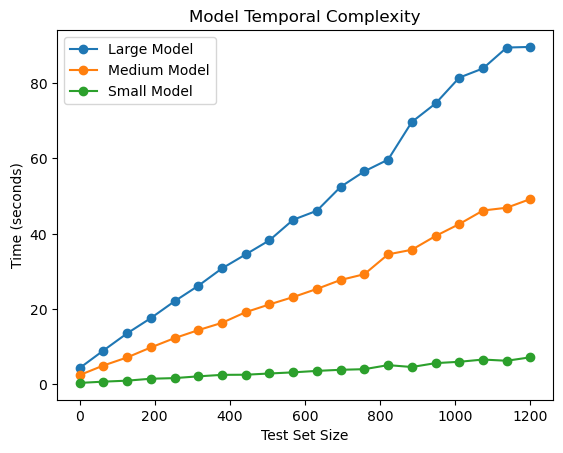

In [204]:
x = np.linspace(0, num_test_points, num_samples)
plt.plot(x, large_times, 'o-', label='Large Model')
plt.plot(x, medium_times, 'o-', label='Medium Model')
plt.plot(x, small_times, 'o-', label='Small Model')


plt.xlabel('Test Set Size')
plt.ylabel('Time (seconds)')
plt.title('Model Temporal Complexity')
plt.legend()
plt.show()

In [1]:
small_average_time = np.mean(np.array((small_times[1:]) - np.array(small_times[:-1])) / (np.array(sample_sizes[1:]) - np.array(sample_sizes[:-1])))
medium_average_time = np.mean(np.array((medium_times[1:]) - np.array(medium_times[:-1])) / (np.array(sample_sizes[1:]) - np.array(sample_sizes[:-1])))
large_average_time = np.mean(np.array((large_times[1:]) - np.array(large_times[:-1])) / (np.array(sample_sizes[1:]) - np.array(sample_sizes[:-1])))

print("Small average time: ", small_average_time)
print("Medium average time: ", medium_average_time)
print("Large average time: ", large_average_time)


NameError: name 'np' is not defined

# Test Subsets

In [57]:
def get_vegetation_subset(vegetation_type):

    X_test_list, y_test_list = [], []
    ssims = []
    for file_num in range(4,30):  
        print(file_num)
        for i in range(16):
            wind_direction_file = wind_direction_file_names[i]
            wind_direction_folder = wind_direction_folder_names[i]

            if not should_use_num(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder, vegetation_type=vegetation_type):
                continue
            # Load data for this file
            U_diff, V_diff, ssim = get_mass_momentum_diff(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder, vegetation_type = vegetation_type, plot=False)
            ssims.append(ssim)
            elevation = get_elevation_file(file_num)
            U_mass, V_mass = get_mass_grid(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder, vegetation_type=vegetation_type)

            # Convert to NumPy arrays (if they aren't already)
            U_diff, V_diff = np.array(U_diff), np.array(V_diff)
            elevation = np.array(elevation)
            U_mass, V_mass = np.array(U_mass), np.array(V_mass)

            # Ensure correct shape (size, size)
            assert U_diff.shape == (size, size) and V_diff.shape == (size, size)
            assert elevation.shape == (size, size)
            assert U_mass.shape == (size, size) and V_mass.shape == (size, size)

            # Stack inputs into a (size, size, 3) tensor
            X_sample = np.stack([elevation, U_mass, V_mass], axis=-1)  # Shape: (size, size, 3)

            # Stack targets into a (size, size, 2) tensor
            y_sample = np.stack([U_diff, V_diff], axis=-1)  # Shape: (size, size, 2)

            # Append to lists
            X_test_list.append(X_sample)
            y_test_list.append(y_sample)

    # Convert lists to NumPy arrays
    X_test = np.array(X_test_list)  # Shape: (10, size, size, 3)
    y_test = np.array(y_test_list)  # Shape: (10, size, size, 2)


    # Convert to TensorFlow tensors
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

    return X_test, y_test, ssims
    
    

In [59]:
X_grass_test, y_grass_test, grass_ssims = get_vegetation_subset('grass')

4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [60]:
X_brush_test, y_brush_test, brush_ssims = get_vegetation_subset('brush')

4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [61]:
X_trees_test, y_trees_test, trees_ssims = get_vegetation_subset('trees')

4


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [68]:
def get_wind_direction_subset(wind_direction_idx):
    X_test_list, y_test_list = [], []
    ssims = []
    wind_direction_file = wind_direction_file_names[wind_direction_idx]
    wind_direction_folder = wind_direction_folder_names[wind_direction_idx]
    for file_num in range(4,30):  
        print(file_num)
        for vegetation_type in ['brush', 'grass', 'trees']:
            if not should_use_num(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder, vegetation_type=vegetation_type):
                continue
            # Load data for this file
            U_diff, V_diff, ssim = get_mass_momentum_diff(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder, vegetation_type = vegetation_type, plot=False)
            ssims.append(ssim)
            elevation = get_elevation_file(file_num)
            U_mass, V_mass = get_mass_grid(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder, vegetation_type=vegetation_type)

            # Convert to NumPy arrays (if they aren't already)
            U_diff, V_diff = np.array(U_diff), np.array(V_diff)
            elevation = np.array(elevation)
            U_mass, V_mass = np.array(U_mass), np.array(V_mass)

            # Ensure correct shape (size, size)
            assert U_diff.shape == (size, size) and V_diff.shape == (size, size)
            assert elevation.shape == (size, size)
            assert U_mass.shape == (size, size) and V_mass.shape == (size, size)

            # Stack inputs into a (size, size, 3) tensor
            X_sample = np.stack([elevation, U_mass, V_mass], axis=-1)  # Shape: (size, size, 3)

            # Stack targets into a (size, size, 2) tensor
            y_sample = np.stack([U_diff, V_diff], axis=-1)  # Shape: (size, size, 2)

            # Append to lists
            X_test_list.append(X_sample)
            y_test_list.append(y_sample)

    # Convert lists to NumPy arrays
    X_test = np.array(X_test_list)  # Shape: (10, size, size, 3)
    y_test = np.array(y_test_list)  # Shape: (10, size, size, 2)


    # Convert to TensorFlow tensors
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

    return X_test, y_test

In [69]:
X_wind_tests = {}
y_wind_tests = {}

for i in range(16):
    print(i)
    X_wind_tests[i], y_wind_tests[i] = get_wind_direction_subset(i)

0
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
1
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
2
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
4
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
5
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
6
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
7
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
8
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
9
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
10
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
11
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
12
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
13
4
5
6
7
8
9
10
11
12
13
14
15
16

In [63]:
def get_metrics_subset(X_test, y_test):
    predictions = large_model.predict(X_test) 

    mse = mean_squared_error(y_test.numpy().flatten(), predictions.flatten())
    mae = mean_absolute_error(y_test.numpy().flatten(), predictions.flatten())
    ssim = structural_similarity(y_test.numpy().flatten(), predictions.flatten(), data_range = np.max(y_test.numpy().flatten()) - np.min(y_test.numpy().flatten()))
    return mse, mae, ssim
    

In [64]:
grass_mse, grass_mae, grass_ssim = get_metrics_subset(X_grass_test, y_grass_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step


In [65]:
brush_mse, brush_mae, brush_ssim = get_metrics_subset(X_brush_test, y_brush_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step


In [66]:
trees_mse, trees_mae, trees_ssim = get_metrics_subset(X_trees_test, y_trees_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step


In [67]:
print("GRASS:", grass_mse,grass_mae, grass_ssim)
print("BRUSH:", brush_mse, brush_mae, brush_ssim)
print("TREES: ", trees_mse, trees_mae, trees_ssim)

GRASS: 1.3032358 0.7218334 0.8117594471620478
BRUSH: 1.262613 0.7011692 0.8443506183152856
TREES:  1.9277033 0.98992044 0.631003466932965


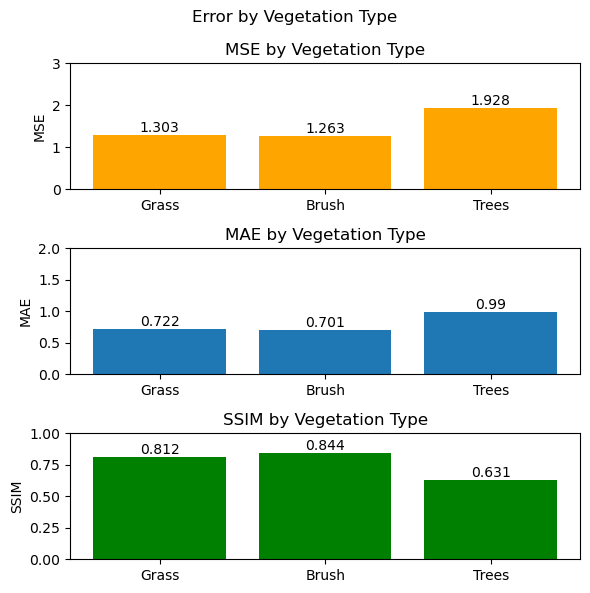

In [116]:


fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
vegetation_labels = ['Grass', 'Brush', 'Trees']
veg_x = np.arange(0,3)- bar_width
veg_x_1 = np.arange(0,3)+bar_width

vegetation_mse = [grass_mse, brush_mse, trees_mse]
vegetation_mae = [grass_mae, brush_mae, trees_mae]
vegetation_ssim = [grass_ssim, brush_ssim, trees_ssim]
ax1_bars = ax1.bar(vegetation_labels, vegetation_mse, label='MSE', color='orange')
ax2_bars = ax2.bar(vegetation_labels, vegetation_mae, label="MSE")
ax3_bars = ax3.bar(vegetation_labels, vegetation_ssim, label='SSIM', color='green')

ax1.set_title("MSE by Vegetation Type")
ax2.set_title("MAE by Vegetation Type")
ax3.set_title("SSIM by Vegetation Type")

ax1.set_ylabel("MSE")
ax2.set_ylabel("MAE")
ax3.set_ylabel("SSIM")

ax1.set_ylim(0,3)
ax2.set_ylim(0,2)
ax3.set_ylim(0,1)

plots_bars = [ax1_bars, ax2_bars, ax3_bars]
plots = [ax1, ax2, ax3]
for plot, plots_bars in zip(plots, plots_bars):
    for bar in plots_bars:
        height = bar.get_height()
        plot.text(bar.get_x() + bar.get_width() / 2, height,
                str(round(height, 3)), ha='center', va='bottom')

fig.suptitle("Error by Vegetation Type")
fig.tight_layout()
plt.show()


In [71]:
wind_mse = []
wind_mae = []
wind_ssim = []
for i in range(16):
    mse, mae, ssim = get_metrics_subset(X_wind_tests[i], y_wind_tests[i])
    wind_mse.append(mse)
    wind_mae.append(mae)
    wind_ssim.append(ssim)
    print(i, mse, mae, ssim)


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
0 1.4665663 0.76347905 0.7112285322160528
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
1 1.5066625 0.81352603 0.7025257230258156
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2 1.6333504 0.865012 0.7197414002148236
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
3 1.5934029 0.8254706 0.7345747988320925
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
4 1.6458504 0.8211859 0.6954838533790434
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
5 1.4065379 0.7957008 0.7300720485368045
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
6 1.3746068 0.8202982 0.7048552615478145
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
7 1.3798225 0.78178567 0.7039605253498847
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
8 1.4464203 0.7656683 0.6962296915261906
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
9 1.5025811 0.80199033 0.7215604482337267
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
10 1.5463462 0.8501764 0.6793520682692148
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
11 1.5637481 0.82545835 0.6997062182251251
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
12 1.6400449 0.79687136 0.72655227

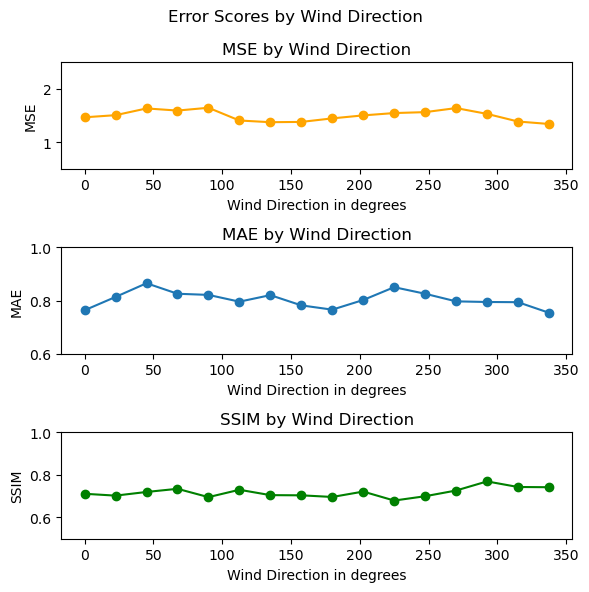

In [130]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
wind_x = np.arange(16)*22.5


ax1.plot(wind_x, wind_mse, 'o-', label='MSE', color='orange')
ax2.plot(wind_x, wind_mae, 'o-', label="MSE")
ax3.plot(wind_x, wind_ssim, 'o-', label='SSIM', color='green')

ax1.set_title("MSE by Wind Direction")
ax2.set_title("MAE by Wind Direction")
ax3.set_title("SSIM by Wind Direction")

ax1.set_ylabel("MSE")
ax2.set_ylabel("MAE")
ax3.set_ylabel("SSIM")

ax1.set_xlabel("Wind Direction in degrees")
ax2.set_xlabel("Wind Direction in degrees")
ax3.set_xlabel("Wind Direction in degrees")

ax1.set_ylim(0.5,2.5)
ax2.set_ylim(0.6,1)
ax3.set_ylim(0.5,1)

fig.suptitle("Error Scores by Wind Direction")

fig.tight_layout()
plt.show()
